In [1]:
import os
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import enchant
from sklearn.neighbors import NearestNeighbors
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
initial_categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                      'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
                      'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast',
                      'talk.politics.misc', 'talk.religion.misc']
eng_dict = enchant.Dict('en_US')

In [3]:
ng_train = fetch_20newsgroups(subset='train', categories=initial_categories, remove=('headers', 'footers', 'quotes'))
print ng_train.keys()

['description', 'DESCR', 'filenames', 'target_names', 'data', 'target']


In [4]:
data_train = []

for el in ng_train.data:
    filtered = re.findall(u'(?u)\\b\\w\\w+\\b', el)
    filtered = [filt for filt in filtered if eng_dict.check(filt)]
    data_train.append(' '.join(filtered).lower())
    
print len(data_train)

8401


In [5]:
tfidf_train = vectorizer.fit_transform(data_train)

print tfidf_train.shape

(8401, 31911)


In [6]:
tfidf_train

<8401x31911 sparse matrix of type '<type 'numpy.float64'>'
	with 446838 stored elements in Compressed Sparse Row format>

In [7]:
valid_inds = []

for i_el, el in enumerate(tfidf_train):
    if el.getnnz() > 0:
        valid_inds.append(i_el)
        
valid_inds = np.asarray(valid_inds)
print len(valid_inds)
        
tfidf_train_filt = tfidf_train[valid_inds]
print tfidf_train_filt.shape

8144
(8144, 31911)


In [8]:
np.save('tf-idf_train', tfidf_train_filt)

In [9]:
predictor = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(tfidf_train_filt)

---

In [10]:
request = 'something about computers electronic components harware etc'

In [12]:
tfidf_test = vectorizer.transform([vectorizer.decode(request)])

print tfidf_test.shape

(1, 31911)


In [13]:
tfidf_test

<1x31911 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [14]:
distances, inds_pred = predictor.kneighbors(tfidf_test, n_neighbors=10)

In [20]:
distances = np.squeeze(distances)
inds_pred = np.squeeze(inds_pred)

(0, 1)

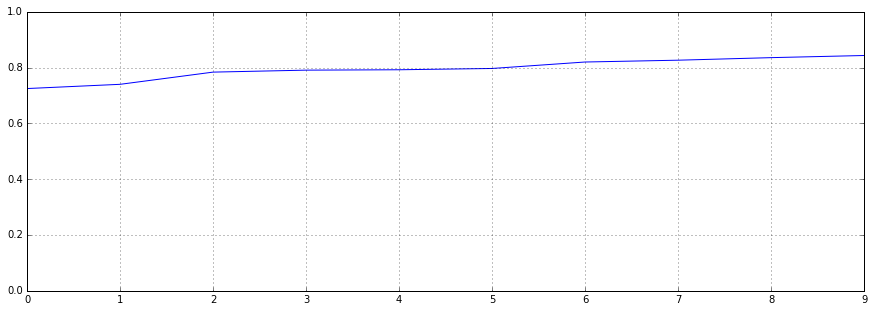

In [23]:
plt.figure(figsize=(15, 5))

plt.plot(distances)
plt.grid(True)
plt.ylim(0, 1)

In [24]:
for i, item in enumerate(np.asarray(ng_train.data)[valid_inds[inds_pred]], start=1):
    print '--------------------------- Top-{} ---------------------------'.format(i)
    print item
    print '---------------------------- end -----------------------------'
    print

--------------------------- Top-1 ---------------------------

 Computers are a special case.. and it's a pretty good idea to
 leave them on.. cuz everytime you turn on a computer, you're 
 putting a surge of electricity through its delicate components.
  Imagine you're turning on your computer 5 or more times a day.
 You're increasing the chances of damaging the chips, memory,
 etc on all the components of your computer. So you may save
 a few cents here and there in electricity bills, but it won't
 look like much when it come time to fix your computer.
---------------------------- end -----------------------------

--------------------------- Top-2 ---------------------------

Good point...also, I wouldn't be surprised that the components
they use off-shore are of inferior quality.  As long as it was
properly designed and robust, premium components are used, it
shouldn't matter where it is assembled.


An amp that runs hot has no bearing on how it's gonna sound.
The amp you have prob